In [144]:
# All the required imports
import torch
import torchvision
from torch import nn

# Setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cpu'

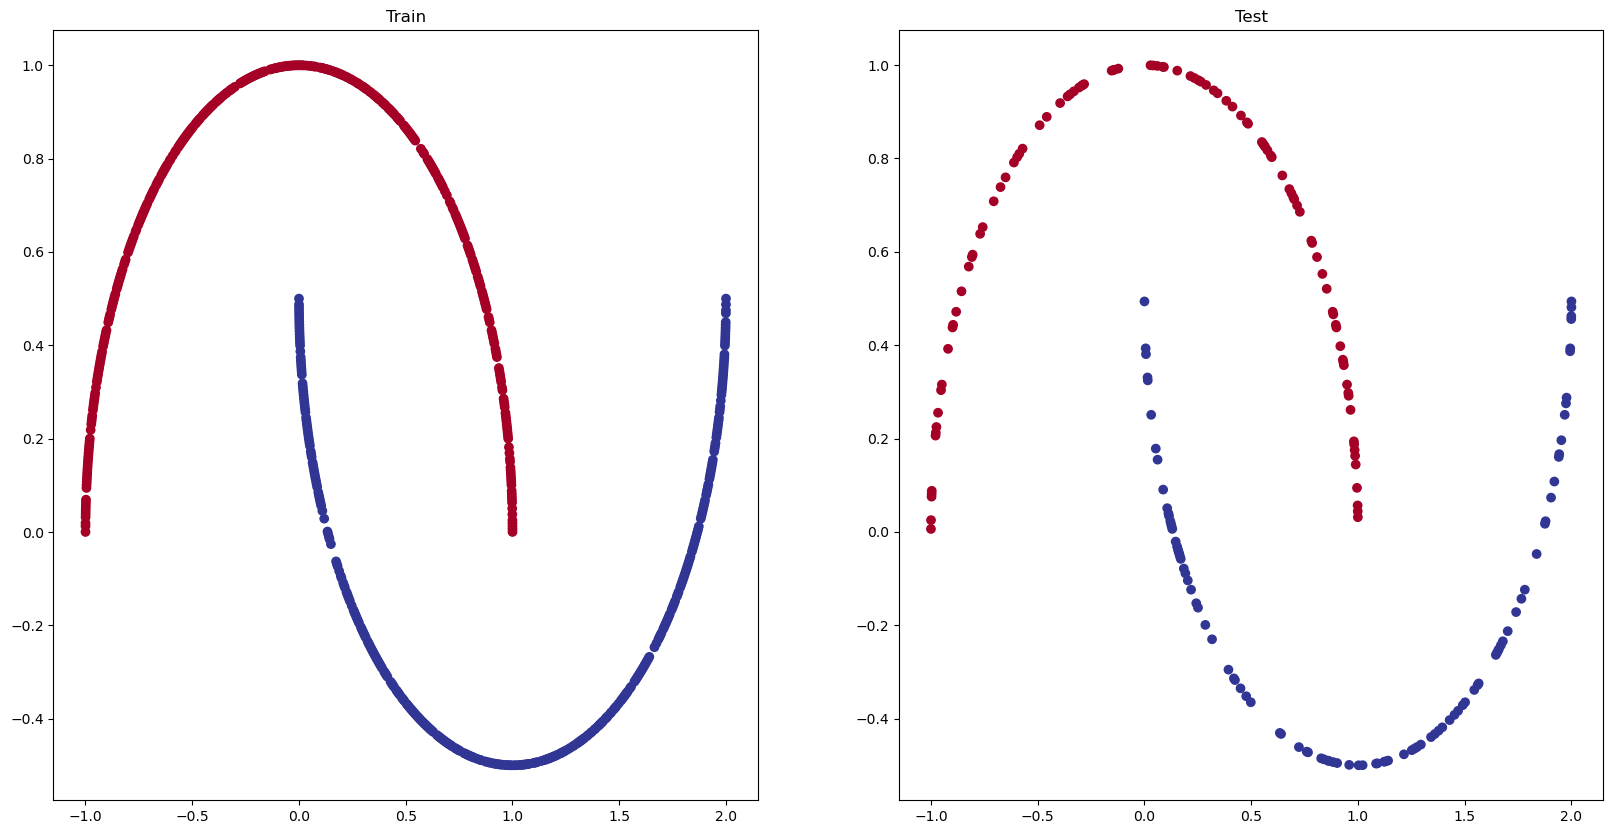

In [145]:
# Creating the dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Creting the dataset
X , y = make_moons(n_samples = 1000, random_state = 42)

# Converting array to tensor
X = torch.from_numpy(X)
y = torch.from_numpy(y)

# Creating the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Visualizing the results
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Train')
plt.scatter(X_train[:,0], X_train[:,1],c = y_train, cmap=plt.cm.RdYlBu)
plt.subplot(1,2,2)
plt.title('Test')
plt.scatter(X_test[:,0], X_test[:,1],c = y_test, cmap=plt.cm.RdYlBu)


In [146]:
# Seeing the different classificattions
y_train.unique()

tensor([0, 1])

In [147]:
X_train.dtype

torch.float64

In [148]:
# Building the Neural Network architecture

class MoonClassifier(nn.Module):
    def __init__(self, hidden_units = 10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features = 2, out_features = hidden_units),
            nn.Tanh(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Tanh(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Tanh(),
            nn.Linear(in_features = hidden_units, out_features = 1)


        )

    def forward(self, x):
        return self.layers(x)

model = MoonClassifier()

model.to(device)


MoonClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [149]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.1)

In [150]:
# Building the training and testing loops
from torchmetrics import Accuracy
torchmetric_accuracy = Accuracy(task = 'binary')

# Ensuring the train and test sets are on the correct device
X_train, y_train = X_train.to(device).float(), y_train.to(device).float()
X_test, y_test = X_test.to(device).float(), y_test.to(device).float()

# Defining the number of epochs
epochs = 1000

for epoch in range(epochs):
    # Training
    model.train()

    # 1. Forward Pass
    y_logits = model(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = torchmetric_accuracy(y_preds, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backwards propagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():

        # 1. Forward Pass
        test_logits = model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculating the loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = torchmetric_accuracy(test_preds, y_test)

        if epoch % 100 == 0:
            print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}')



Epoch: 0 | Loss: 0.69065, Acc: 0.50 | Test loss: 0.68872, Test acc: 0.66
Epoch: 100 | Loss: 0.28609, Acc: 0.87 | Test loss: 0.29040, Test acc: 0.88
Epoch: 200 | Loss: 0.24839, Acc: 0.89 | Test loss: 0.24375, Test acc: 0.90
Epoch: 300 | Loss: 0.23175, Acc: 0.90 | Test loss: 0.22653, Test acc: 0.90
Epoch: 400 | Loss: 0.16990, Acc: 0.93 | Test loss: 0.16519, Test acc: 0.93
Epoch: 500 | Loss: 0.06313, Acc: 0.99 | Test loss: 0.06100, Test acc: 0.98
Epoch: 600 | Loss: 0.02389, Acc: 1.00 | Test loss: 0.02299, Test acc: 1.00
Epoch: 700 | Loss: 0.01279, Acc: 1.00 | Test loss: 0.01228, Test acc: 1.00
Epoch: 800 | Loss: 0.00830, Acc: 1.00 | Test loss: 0.00796, Test acc: 1.00
Epoch: 900 | Loss: 0.00599, Acc: 1.00 | Test loss: 0.00574, Test acc: 1.00


In [151]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


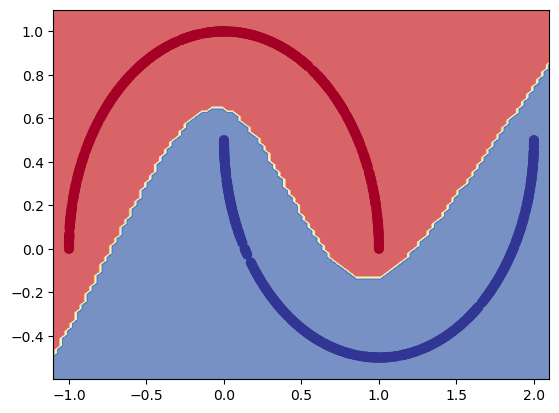

In [152]:
import numpy as np
plot_decision_boundary(model,X_train, y_train)